In [74]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt

In [75]:
# 读入 ab_test_imp（关于广告曝光次数的信息）数据
ab_test_imp_table = pd.read_csv('./data/section5-ab_test_imp.csv')
ab_test_imp_table.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,36703,25622
1,2013-10-01,game-01,sales_test,A,44339,25623
2,2013-10-01,game-01,sales_test,B,32087,25624
3,2013-10-01,game-01,sales_test,B,10160,25625
4,2013-10-01,game-01,sales_test,B,46113,25626


In [76]:
# 读入 ab_test_goal（关于广告点击次数的信息）数据
ab_test_goal_table = pd.read_csv('./data/section5-ab_test_goal.csv')
ab_test_goal_table.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,15021,25638
1,2013-10-01,game-01,sales_test,B,351,25704
2,2013-10-01,game-01,sales_test,B,8276,25739
3,2013-10-01,game-01,sales_test,B,1230,25742
4,2013-10-01,game-01,sales_test,B,17471,25743


In [77]:
# 合并 ab_test_imp 和 ab_test_goal
merge_table = pd.merge(ab_test_imp_table,ab_test_goal_table,how='left',left_on='transaction_id',right_on='transaction_id',sort=True)
merge_table = merge_table.rename(columns = {'app_name_x': 'app_name','log_date_x':'log_date','test_name_x':'test_name','test_case_x':'test_case','user_id_x':'user_id','log_date_y':'click_date'})
merge_table = merge_table[['transaction_id','log_date','click_date','test_case','user_id']]
merge_table.head()

,transaction_id,log_date,click_date,test_case,user_id
0,1,2013-10-02,NaN,A,49017
1,2,2013-10-02,NaN,B,49018
2,3,2013-10-02,NaN,A,44338
3,4,2013-10-02,NaN,A,44339
4,5,2013-10-02,NaN,A,28598


In [78]:
# 生成新列，记录是否被点击
merge_table['是否被点击'] = merge_table['click_date'].apply(lambda x: 1 if str(x) != 'nan' else 0)
merge_table = merge_table[['transaction_id','log_date','test_case','user_id','是否被点击']]
merge_table.head()

,transaction_id,log_date,test_case,user_id,是否被点击
0,1,2013-10-02,A,49017,0
1,2,2013-10-02,B,49018,0
2,3,2013-10-02,A,44338,0
3,4,2013-10-02,A,44339,0
4,5,2013-10-02,A,28598,0


In [100]:
# 统计点击率
pivot_click_rate = pd.pivot_table(merge_table,index=['test_case'],values=['user_id'],columns=['是否被点击'],aggfunc='count',margins=True)
pivot_click_rate['点击率'] = pivot_click_rate['user_id',1] / pivot_click_rate['user_id','All']
pivot_click_rate['点击率'] = pivot_click_rate['点击率'].apply(lambda x: format(x, '.2%'))
pivot_click_rate = pivot_click_rate[['点击率']]
pivot_click_rate

,点击率
是否被点击,
test_case,
A,8.03%
B,11.55%
All,9.78%


In [101]:
# 进行卡方检验(双变量差异性因素的显著性检验)
kf_data = pd.crosstab(merge_table['test_case'],merge_table['是否被点击'],margins=False)
kf = chi2_contingency(kf_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%kf)

chisq-statistic=308.3751, p-value=0.0000, df=1 expected_frep=[[39818.18029207  4315.81970793]
 [39507.81970793  4282.18029207]]


In [162]:
# 计算每天的点击率
pivot_click_rate_per_day = pd.pivot_table(merge_table,index=['log_date','test_case'],values=['user_id'],columns=['是否被点击'],aggfunc='count',margins=True)
pivot_click_rate_per_day['点击率'] = pivot_click_rate_per_day['user_id',1] / pivot_click_rate_per_day['user_id','All']
pivot_click_rate_per_day = pivot_click_rate_per_day['点击率']
pivot_click_rate_per_day = pivot_click_rate_per_day.reset_index()
pivot_click_rate_per_day['日期'] = pivot_click_rate_per_day['log_date'].map(lambda x: x.replace('2013-',''))
pivot_click_rate_per_day = pivot_click_rate_per_day[['test_case','日期','点击率']]
pivot_click_rate_per_day = pivot_click_rate_per_day[pivot_click_rate_per_day['日期'] != 'All']
pivot_click_rate_per_day['点击率均值'] = pivot_click_rate_per_day['点击率'].mean()
# pivot_click_rate_per_day['点击率'] = pivot_click_rate_per_day['点击率'].apply(lambda x: format(x, '.2%'))
# pivot_click_rate_per_day['点击率均值'] = pivot_click_rate_per_day['点击率均值'].apply(lambda x: format(x, '.2%'))
pivot_click_rate_per_day

,test_case,日期,点击率,点击率均值
0,A,10-01,0.072165,0.098351
1,B,10-01,0.126528,0.098351
2,A,10-02,0.064234,0.098351
3,B,10-02,0.159040,0.098351
4,A,10-03,0.140148,0.098351
...,...,...,...,...
57,B,10-29,0.106383,0.098351
58,A,10-30,0.077181,0.098351
59,B,10-30,0.163851,0.098351
60,A,10-31,0.047970,0.098351


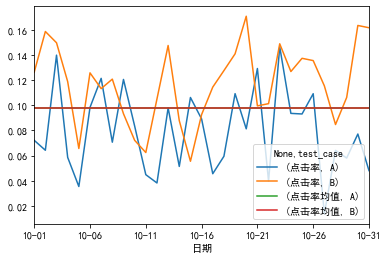

In [166]:
# 结果可视化
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

df =  pd.pivot_table(pivot_click_rate_per_day,index=['日期'],values=['点击率','点击率均值'],columns=['test_case'],aggfunc='sum')
df.plot(kind='line')